<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/retrieval_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks"

/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks


In [3]:
%run vpt_index.ipynb

In [4]:
import time
from statistics import median
import numpy as np
import pandas as pd
import random
import math
import pickle
import keras
from IPython.display import display
from ipywidgets import HBox, Image, HTML
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

In [5]:
%cd "/content/"

/content


# Download Dataset

In [6]:
# Dataset download 

! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d davidedemarco/healthy-unhealthy-plants-dataset-segmented --unzip

# downaload the noise images from https://drive.google.com/file/d/1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm/view?usp=sharing



Saving kaggle.json to kaggle (1).json
 98% 632M/642M [00:03<00:00, 189MB/s]
100% 642M/642M [00:03<00:00, 179MB/s]


In [7]:
! mv /content/Healthy\ \&\ Unhealthy\ Plants\ Dataset\ Segmented /content/Healthy-Unhealthy-Plants-Dataset-Segmented

In [8]:
! gdown --id 1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm -O noise.zip

! unzip /content/noise.zip

Downloading...
From: https://drive.google.com/uc?id=1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm
To: /content/noise.zip
100% 3.08G/3.08G [00:52<00:00, 58.4MB/s]
Archive:  /content/noise.zip
replace mirflickr25k/mirflickr/doc/common_tags.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
dataframe = pd.read_csv("/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/dataframe1.csv")
dataframe = dataframe.drop('Unnamed: 0', 1)
dataframe

,Image,Plant,Path
0,ca66c694-e8cb-47df-84af-b4c46de1fd3e___RS_HL 7...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
1,00365.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
2,22570.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
3,0576bbc4-37b3-413c-8a35-4138c2da69a7___RS_HL 8...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
4,0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
...,...,...,...
97029,im22820.jpg,noise,/content/mirflickr25k/mirflickr/im22820.jpg
97030,im6500.jpg,noise,/content/mirflickr25k/mirflickr/im6500.jpg
97031,im10060.jpg,noise,/content/mirflickr25k/mirflickr/im10060.jpg
97032,im5074.jpg,noise,/content/mirflickr25k/mirflickr/im5074.jpg


# Useful Paths



In [10]:
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features.npy"
FEATURES_FINETUNED_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/finetuned_features_t.npy"
DATAFRAME_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/dataframe1.csv"

# VPT Index Creation

## VPT with unfinetuned model

Create the VPT index using the features extracted with pretrainet network *DenseNet121* 


In [ ]:
features = np.load(FEATURES_PATH)

vp_tree_index = VantagePointTree(features, distance_measure="euclidian", size=len(features))

Building time: 32.34 sec


We can save the index created to avoid the computation each time.

In [ ]:
vp_tree_index.save_on_disk("saved_tree.pkl")

In [ ]:
! mv saved_tree.pkl /content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/

If the index is stored in gdrive we can load 

In [ ]:
with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
vp_tree_index = VantagePointTree(root=new_root, size = len(features),from_disk=True, distance_measure="euclidian")

Building time: 0.00 sec


## VPT with finetuned model

Create the VPT index using the features extracted with pretrainet network *DenseNet121* 


In [12]:
features_ft = np.load(FEATURES_FINETUNED_PATH)

vp_tree_index_ft = VantagePointTree(features_ft, distance_measure="euclidian", size=len(features_ft))

Distance measure: euclidian
Pivot choice: Random
Vantage Point Tree index in construction...
Building time: 32.07 sec


We can save the index created to avoid the computation each time.

In [ ]:
vp_tree_index_ft.save_on_disk("saved_tree.pkl")

In [ ]:
! mv saved_tree.pkl /content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine

If the index is stored in gdrive we can load 

In [ ]:
with open('saved_tree.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

new_root = Node.from_dict(loaded_dict)
vp_tree_index_ft = VantagePointTree(root=new_root, size = len(features_ft),from_disk=True, distance_measure="euclidian")

Distance measure: euclidian
Pivot choice: Random
Tree retrieved from disk
Building time: 0.00 sec


# Loading Model

## Unfinetuned Model

In [ ]:
model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

29097984/29084464 [==============================] - 0s 0us/step


## Finetuned Model

In [28]:
model_ft = keras.models.load_model('/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned_vecchio')
finetuned_model = keras.models.Model(inputs=model_ft.input, outputs=model_ft.get_layer('gap').output)

# Query Feature Extraction

In [64]:
query_index = 63340
QUERY_PATH = dataframe.Path.iloc[query_index]
print(QUERY_PATH)

/content/Healthy-Unhealthy-Plants-Dataset-Segmented/Tomato/40985.jpg


In [65]:
def extract_features(query_path, model):
  image_width = 224
  image_height = 224
  image_size = (image_height, image_width)
  query_image_pil = tf.keras.utils.load_img(query_path, target_size=image_size, interpolation='bilinear')
  query_image_np = tf.keras.preprocessing.image.img_to_array(query_image_pil)
  query_image_np = np.expand_dims(query_image_np, axis=0)  # add batch dimension
  query_features = model(query_image_np)
  return query_features

tf.Tensor(
[[8.6888242e-05 3.5264008e-04 4.4120052e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]], shape=(1, 1024), dtype=float32)


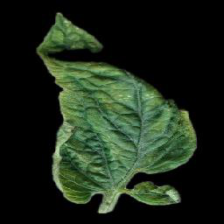

In [66]:
query_features = extract_features(QUERY_PATH, finetuned_model)
print(query_features)

query_image_pil = tf.keras.utils.load_img(QUERY_PATH, target_size=(224,224), interpolation='bilinear')
query_image_pil

In [67]:
k = 10

query_object = Object(query_features.numpy(), query_index)
kNN, dNN, distance_computations, time_kNN = vp_tree_index_ft.search_kNN(query_object,k)

print(f"Ho computato {distance_computations} su {vp_tree_index_ft.size} oggetti nell'indice in {time_kNN:.2f} sec.")

Ho computato 43085 su 97034 oggetti nell'indice in 0.87 sec.


In [68]:
paths = dataframe['Path'].to_numpy()
labels = dataframe['Plant']

kNN_paths = [paths[int(obj.id)] for obj in kNN]
kNN_labels = [labels[int(obj.id)] for obj in kNN]

show_results(kNN_paths, dNN, kNN_labels)

In [62]:
def show_results(image_paths, scores, captions=None):
  """
  Shows results of a similarity search. Lists of image paths, scores, and
  (optionally) captions must be of the same length and follow the same order.
  
  Args:
    image_paths (ndarray or list): ordererd paths of images to be shown.
    scores (ndarray or list): ordered scores values to be shown next to images.
    captions (ndarray or list): ordered strings of captions to be shown; if
                                None, no caption is shown. Defaults to None.
  
  """
  if captions is None:
    captions = [''] * len(scores)  # just all empty strings

  for image_path, score, caption in zip(image_paths, scores, captions):
    title = 'score: {:.6f}'.format(score)
    display_image(image_path, title, caption)

In [63]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)